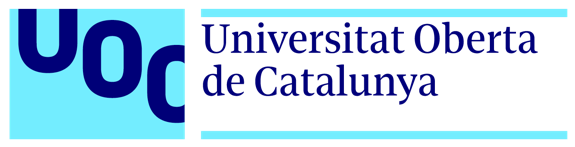

In [1]:
# Librerías de manipulación de datos
import pandas as pd
import numpy as np
import joblib

# Librerías de visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.legend_handler import HandlerLine2D

# Librerías de procesaso de datos
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

1. Carga de los datos

2. Funciones generales

3. Generación árbol de decisión

4. Evaluación árbol de decisión

5. Características importantes

6. Guardado del mejor modelo

# 1. Carga de los datos

In [2]:
data = pd.read_csv("../data/case_control_episode.csv")
data.head()

,BreastCancer,Age,Family_History,episode_1,episode_2,episode_3,episode_4,episode_5,episode_6,episode_7,...,bbd_none,bbd_unknown,bbd_no_proliferative,bbd_proliferative,mf_none,mf_mass,mf_calcification,mf_asymetric_density,mf_distorsion,mf_multiple_patron
0,0.0,0.368421,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.105263,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.052632,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.210526,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# 2. Funciones generales

In [3]:
def grid_search(model, params, X_train, y_train):
    """
    Función genérica para aplicar la búsqueda de rejilla
    al modelo determinado mediante validación cruzada
    Args:
        model: modelo a aplicar a la búsqueda
        params: parámetros a comprobar
        X_train: datos de entrenamiento de los factores
        y_train: datos de entrenamiento de la clase
        cv: validación cruzada a aplicar
    Returns:
        Devuelve el mejor estimador entrenado
    """
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    
    model_search = GridSearchCV(estimator=model, param_grid=params,
                                scoring='accuracy', n_jobs=-1, cv=cv, refit=True)

    # Se entrena el mejor estimados
    model_search.fit(X_train, y_train)
    
    print("Los mejores parámetros son:", model_search.best_params_)

    return model_search

In [4]:
def evaluate_model(model, X_test, y_test):
    """
    Función genérica para evaluar los modelos
    Args:
        model: modelo a aplicar a la búsqueda
        X_test: datos de test de los factores
        y_test: datos de test de la clase
    """
    y_pred_test = model.predict(X_test)
    
    test_confusion_matrix = confusion_matrix(y_test, y_pred_test)
    
    print("-"*50)
    print("Accuracy en test: ", accuracy_score(y_test, y_pred_test))
    print("-"*50)
    print("AUC: ", roc_auc_score(y_test, y_pred_test))
    print("-"*50)
    print("Clasificación en test: ")
    print(classification_report(y_test, y_pred_test))
    print("-"*50)
    print("Matriz de confusión en test: ")
    print(test_confusion_matrix)
    print("-"*50)
    sns.set(font_scale=1.4)
    dt_cm = sns.heatmap(test_confusion_matrix, annot=True, annot_kws={"size": 12}, fmt="g")
    plt.xlabel("Valores predichos")
    plt.ylabel("Valores reales")
    plt.yticks(fontsize=11)
    plt.xticks(fontsize=11)
    plt.show()
    figure = dt_cm.get_figure()
    figure.savefig("../plots/dt_model_confusion_matrix.png", bbox_inches="tight")


# 3. Generación árbol de decisión

## 3.1 Partición de los datos

In [5]:
# Partición de los datos en entrenamiento y test con una proporción 85/15

X = data.iloc[:, data.columns != "BreastCancer"].values.astype(float)
y = data.iloc[:, data.columns == "BreastCancer"].values.astype(float)

# Repartición balanceada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=12)

## 3.2 Definición parámetros

In [6]:
dt_grid = {
    "min_samples_leaf": list(range(40, 60)),
    "min_samples_split": list(range(90, 110)),
    "max_leaf_nodes": list(range(65, 85)),
    "max_features": list(range(10, 15)),
    "random_state": [18],
}

## 3.3. Definición árbol de decisión

In [7]:
model = DecisionTreeClassifier()

## 3.4 Búsqueda de rejilla

In [8]:
%%time

result = grid_search(model, dt_grid, X_train, y_train)
    
# Mejor estimador
best_model = result.best_estimator_

Los mejores parámetros son: {'max_features': 11, 'max_leaf_nodes': 80, 'min_samples_leaf': 48, 'min_samples_split': 97, 'random_state': 18}
CPU times: user 4min 39s, sys: 22.2 s, total: 5min 1s
Wall time: 16min 5s


# 4. Evaluación árbol de decisión

Precisión media sobre train, validación cruzada: 60.22 +/- 0.93 %
--------------------------------------------------
Accuracy en test:  0.6220385674931129
--------------------------------------------------
AUC:  0.6217491648952322
--------------------------------------------------
Clasificación en test: 
              precision    recall  f1-score   support

         0.0       0.63      0.64      0.63       925
         1.0       0.62      0.61      0.61       890

    accuracy                           0.62      1815
   macro avg       0.62      0.62      0.62      1815
weighted avg       0.62      0.62      0.62      1815

--------------------------------------------------
Matriz de confusión en test: 
[[589 336]
 [350 540]]
--------------------------------------------------


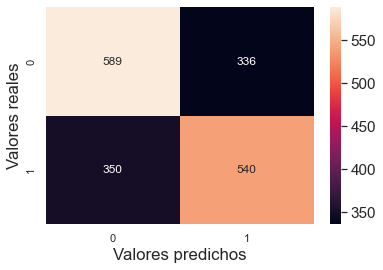

In [9]:
# Validación cruzada para determinar la confiabilidad del modelo
cv = KFold(n_splits=5, shuffle=True, random_state=1)
cvscores_random = cross_val_score(best_model, X_train, y_train, cv = cv)

print("Precisión media sobre train, validación cruzada: "
      "{:.2f} +/- {:.2f} %".format(np.mean(cvscores_random)*100, np.std(cvscores_random)*100))
    
# Muestra de resultados sobre el mejor modelo
evaluate_model(best_model, X_test, y_test)

# 5. Características importantes

Age                     0.068566
Family_History          0.011317
episode_1               0.029149
episode_2               0.015712
episode_3               0.000194
episode_4               0.000000
episode_5               0.000233
episode_6               0.000408
episode_7               0.000000
episode_8               0.000000
episode_9               0.000000
episode_10              0.000000
bbd_none                0.004259
bbd_unknown             0.001342
bbd_no_proliferative    0.001595
bbd_proliferative       0.000719
mf_none                 0.049781
mf_mass                 0.000000
mf_calcification        0.002120
mf_asymetric_density    0.001458
mf_distorsion          -0.000564
mf_multiple_patron      0.002178
dtype: float64


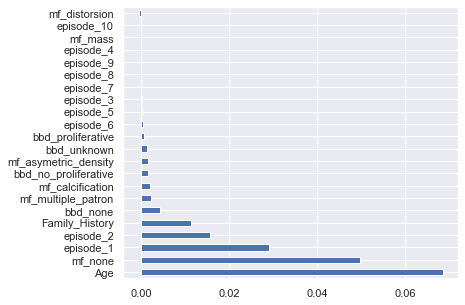

In [10]:
# Importancia de la característica de permutación
perm_importance = permutation_importance(best_model, X_train, y_train)

# Características importantes
importance_features = pd.Series(perm_importance.importances_mean,
                       index=data.iloc[:, 1: 23].columns)

# Muestra de las características
print(importance_features)
plt.figure(figsize=(6, 5))
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
importance_features.nlargest(22).plot.barh()
plt.savefig("../plots/dt_model_feature_importance.png", bbox_inches="tight")

In [11]:
# Se agrupan los resultados por variables originales

episode = importance_features.episode_1 + importance_features.episode_2 + importance_features.episode_3
+ importance_features.episode_4 + importance_features.episode_5 + importance_features.episode_6
+ importance_features.episode_7 + importance_features.episode_8 + importance_features.episode_9
+ importance_features.episode_10

bbd = importance_features.bbd_none + importance_features.bbd_unknown + importance_features.bbd_no_proliferative
+ importance_features.bbd_proliferative

mf = importance_features.mf_none + importance_features.mf_mass + importance_features.mf_calcification
+ importance_features.mf_asymetric_density + importance_features.mf_distorsion
+ importance_features.mf_multiple_patron

features_importance = []
features_importance.extend([])
features_importance.extend((importance_features.Age, episode, importance_features.Family_History, bbd, mf))
features_importance = np.array(features_importance)

Age                      0.068566
Episode                  0.045056
Family_History           0.011317
BBD_History              0.007195
Mammographic_Features    0.051901
dtype: float64


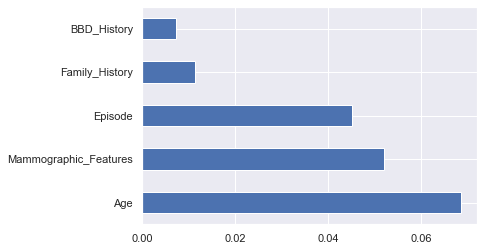

In [12]:
general_feature_importance = pd.Series(features_importance,
                       index=["Age", "Episode", "Family_History", "BBD_History", "Mammographic_Features"])

# Muestra de las características generales
print(general_feature_importance)
plt.figure(figsize=(6,4))
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
general_feature_importance.nlargest(5).plot.barh()
plt.savefig("../plots/dt_model_feature_importance_general.png", bbox_inches="tight")

In [13]:
data_x = data.iloc[:, data.columns != "BreastCancer"]

for i in perm_importance.importances_mean.argsort()[::-1]:
    if perm_importance.importances_mean[i] - 2 * perm_importance.importances_std[i] > 0:
        print(f"{data_x.columns[i]:<8} "
            f"{perm_importance.importances_mean[i]:.4f}"
            f" +/- {perm_importance.importances_std[i]:.4f}")

Age      0.0686 +/- 0.0078
mf_none  0.0498 +/- 0.0014
episode_1 0.0291 +/- 0.0021
episode_2 0.0157 +/- 0.0017
Family_History 0.0113 +/- 0.0025
bbd_none 0.0043 +/- 0.0012
mf_multiple_patron 0.0022 +/- 0.0002
mf_calcification 0.0021 +/- 0.0002
bbd_no_proliferative 0.0016 +/- 0.0001
mf_asymetric_density 0.0015 +/- 0.0005
bbd_proliferative 0.0007 +/- 0.0001
episode_5 0.0002 +/- 0.0001


# 6. Guardado del mejor modelo

In [14]:
joblib.dump(best_model, "../saved_models/dt_model.joblib")

['../saved_models/dt_model.joblib']